# Import package and module

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

In [2]:
tf.config.list_physical_devices("GPU")
!nvidia-smi

Wed May 18 09:39:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:29:00.0  On |                  N/A |
|  0%   50C    P8    20W / 125W |    837MiB /  6144MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load path

In [2]:
try:
    set_pick = int(input("Dataset : \n1. Kaggle\n2. Mendley"))
    if set_pick == 1:
        # Kaggle dataset dir
        train_dir = './cigarette-smoker-detection-kaggle/train'
        test_dir = './cigarette-smoker-detection-kaggle/test'

        print("Kaggle dataset selected")

    elif set_pick == 2:
        # Mendley dataset dir 
        train_dir = './dataset_mendley/training_data'
        val_dir = './dataset_mendley/validation_data'
        test_dir = './dataset_mendley/testing_data'
        
        print("Mendley dataset selected")
    else:
        raise Exception("Input 1 or 2")
except ValueError:
    print("Wrong input value!!!")

Mendley dataset selected


# Preprocessing

### Preprocessing

In [3]:
img_size = 224
batch_size = 32
seed = 72

if set_pick == 1:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

elif set_pick == 2:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 1610 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [4]:
train_ds.class_names

['notsmoking', 'smoking']

## Rescale

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
print("\nRescale Successful")


Rescale Successful


# Train

In [5]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(img_size, img_size, 3),
    weights="imagenet",
    include_preprocessing=False,
    include_top=False,
    pooling="avg"
)

# base_model.trainable = False
for layer in base_model.layers[:-7]:
    layer.trainable = False

In [9]:
model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Dropout(0.5, seed = seed),
                            tf.keras.layers.Dense(units=1, activation = "sigmoid")
])

In [10]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

Model Summary

In [11]:
# model.summary(expand_nested=True)
model.summary()
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True
# )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 156,481
Non-trainable params: 2,840,832
_________________________________________________________________


In [15]:
fb_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

tf.lite.experimental.Analyzer.analyze(model_content=fb_model)

INFO:tensorflow:Assets written to: C:\Users\Aisen\AppData\Local\Temp\tmpva5uu1zw\assets


INFO:tensorflow:Assets written to: C:\Users\Aisen\AppData\Local\Temp\tmpva5uu1zw\assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #43 and tensor #90 as input and produces tensor #131 as output.

Subgraph#0 main(T#0) -> [T#253]
  Op#0 CONV_2D(T#0, T#43, T#90) -> [T#131]
  Op#1 HARD_SWISH(T#131) -> [T#132]
  Op#2 DEPTHWISE_CONV_2D(T#132, T#91, T#22) -> [T#133]
  Op#3 CONV_2D(T#133, T#44, T#92) -> [T#134]
  Op#4 ADD(T#132, T#134) -> [T#135]
  Op#5 CONV_2D(T#135, T#45, T#23) -> [T#136]
  Op#6 PAD(T#136, T#19) -> [T#137]
  Op#7 DEPTHWISE_CONV_2D(T#137, T#93, T#24) -> [T#138]
  Op#8 CONV_2D(T#138, T#46, T#94) -> [T#139]
  Op#9 CONV_2D(T#139, T#47, T#25) -> [T#140]
  Op#10 DEPTHWISE_CONV_2D(T#140, T#95, T#26) -> [T#141]
  Op#11 CONV_2D(T#141, T#48, T#96) -> [T#142]
  Op#12 ADD(T#139, T#142) -> [T#143]
  Op#13 CONV_2D(T#143, T#49, T#27) -> [T#144]
  Op#14 PAD(T#144, T#21) -> [T#145]
  Op#15 DEPTHWISE_CONV_2D(T#145, T

Start train

In [12]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

print("\n==========================")
print("======= Train done =======")
print("==========================")

Epoch 1/300
51/51 [==============================] - 15s 150ms/step - loss: 0.4316 - accuracy: 0.7988 - precision_1: 0.8018 - recall_1: 0.7938 - val_loss: 0.3315 - val_accuracy: 0.8750 - val_precision_1: 0.8788 - val_recall_1: 0.8700
Epoch 2/300
51/51 [==============================] - 8s 138ms/step - loss: 0.2540 - accuracy: 0.8975 - precision_1: 0.8951 - recall_1: 0.9006 - val_loss: 0.3153 - val_accuracy: 0.8750 - val_precision_1: 0.8947 - val_recall_1: 0.8500
Epoch 3/300
51/51 [==============================] - 8s 137ms/step - loss: 0.1792 - accuracy: 0.9286 - precision_1: 0.9312 - recall_1: 0.9255 - val_loss: 0.3034 - val_accuracy: 0.8800 - val_precision_1: 0.9000 - val_recall_1: 0.8550
Epoch 4/300
51/51 [==============================] - 8s 137ms/step - loss: 0.1450 - accuracy: 0.9516 - precision_1: 0.9584 - recall_1: 0.9441 - val_loss: 0.2931 - val_accuracy: 0.8900 - val_precision_1: 0.8824 - val_recall_1: 0.9000
Epoch 5/300
51/51 [==============================] - 8s 136ms/step 

Result #1 train

In [14]:
acc = history_1.history['accuracy']
prec = history_1.history['precision_1']
recall = history_1.history['recall_1']
loss = history_1.history['loss']

val_acc = history_1.history['val_accuracy']
val_prec = history_1.history['val_precision_1']
val_recall = history_1.history['val_recall_1']
val_loss = history_1.history['val_loss']

In [18]:
save_path = './Developed-model/exp12'
model.save(save_path)
print("\nModel has been saved")

INFO:tensorflow:Assets written to: ./Developed-model/exp12\assets


INFO:tensorflow:Assets written to: ./Developed-model/exp12\assets



Model has been saved


In [15]:
print("\nEvaluating the model with test set")
model.evaluate(test_ds)


Evaluating the model with test set
13/13 [==============================] - 3s 104ms/step - loss: 0.3439 - accuracy: 0.9450 - precision_1: 0.9450 - recall_1: 0.9450


[0.3438931703567505,
 0.9449999928474426,
 0.9449999928474426,
 0.9449999928474426]

# Export Fine tune 1 metrics result to csv

In [17]:
data = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
export_data = zip_longest(*data, fillvalue = '')

with open('exp12.csv', 'w', encoding="ISO-8859-1", newline='') as file:
      write = csv.writer(file)
      write.writerow(("acc", "prec", "recall", "loss", "val_acc", "val_prec", "val_recall", "val_loss"))
      write.writerows(export_data)

print("\nTrain result has been saved")


Train result has been saved


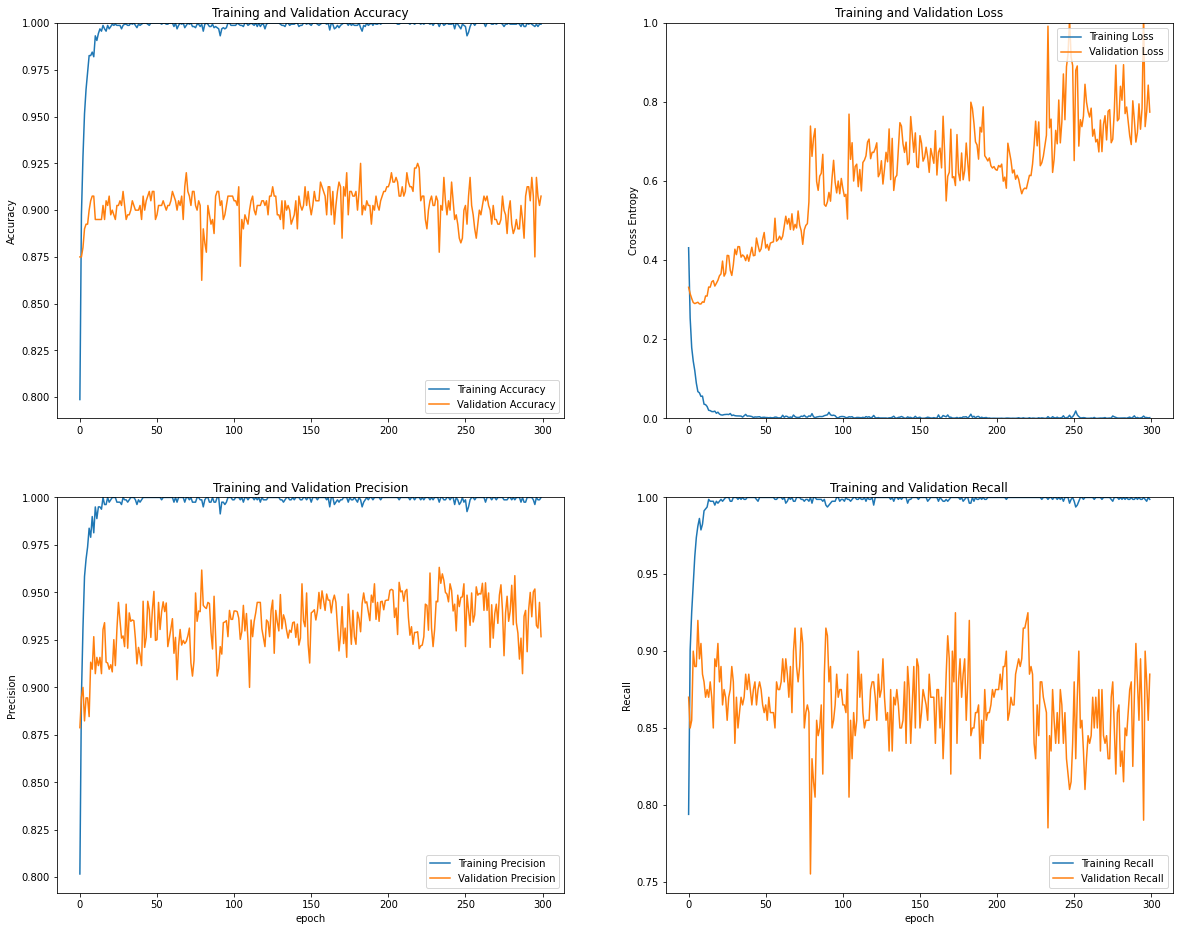

In [16]:
plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()